In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import math
import os
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

from tensorflow.keras.layers import RepeatVector, Dense, Activation, Input, LSTM, GRU, Bidirectional, Concatenate, Dot
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K

### Build the basic LSTM model

In [6]:
def base_model(Tx, n_x, n_a): 
    # Define the input layer and specify the shape
    input = Input(shape=(Tx, n_x))
    
    # build LSTM frame with the time_step = Tx
    all_state = LSTM(n_a, return_sequences=True)(input)

    # Create empty list to append the outputs while you iterate
    outputs = []
    
    # Loop over tx
    for t in range(Tx):
        # Apply densor to the hidden state output of LSTM_Cell
        out = Dense(1, activation='sigmoid')(all_state[:, t, :])
        # add the output to "outputs"
        outputs.append(out)
        
    # Create model instance
    model = Model(inputs=input, outputs=outputs)
    
    return model

### Build the deep Bi-LSTM model

In [7]:
def deep_bi_lstm_model(Tx, n_x, n_a):   
    # Define the input layer and specify the shape
    input = Input(shape=(Tx, n_x))
    
    # build LSTM frame with the time_step = Tx
    x = Bidirectional(LSTM(n_a, return_sequences=True))(input)
    all_state = Bidirectional(LSTM(n_a, return_sequences=True))(x)

    # Create empty list to append the outputs while you iterate
    outputs = []
    
    # Loop over tx
    for t in range(Tx):
        # Apply densor to the hidden state output of LSTM_Cell
        out = Dense(1, activation='sigmoid')(all_state[:, t, :])
        # add the output to "outputs"
        outputs.append(out)
        
    # Create model instance
    model = Model(inputs=input, outputs=outputs)
    
    return model

### Build the attention_based model

In [8]:
def softmax(x, axis=1):
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')

def one_step_attention(a, s_prev):
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" 
    s_prev = RepeatVector(Tx)(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis 
    # For grading purposes, please list 'a' first and 's_prev' second, in this order.
    concat = Concatenate(axis=-1)([a, s_prev])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. 
    e = Dense(8, activation = "tanh")(concat)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. 
    energies = Dense(1, activation = "relu")(e)
    # Use "activator" on "energies" to compute the attention weights "alphas" 
    alphas = Activation(softmax)(energies)
    # Use dotor together with "alphas" and "a", in this order, to compute the context vector to be given to the next (post-attention) LSTM-cell
    context = Dot(axes = 1)([alphas,a])
    
    return context


def attention_model(Tx, n_a, n_s, n_x):
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 (initial hidden state) and c0 (initial cell state) for the decoder LSTM with shape (n_s,)
    X = Input(shape=(Tx, n_x))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    # Step 1: Define the encoder with Bi-LSTM. 
    a = Bidirectional(LSTM(units=n_a, return_sequences=True))(X)
    
    # Step 2: Define decoder iterating for Tx steps
    for t in range(Tx):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t 
        context = one_step_attention(a, s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        s, _, c = LSTM(n_s, return_state = True)(inputs=context, initial_state=[s, c])
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM 
        out = Dense(1, activation='sigmoid')(s)
        
        # Step 2.D: Append "out" to the "outputs" list 
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs. 
    model = Model(inputs=[X,s0,c0], outputs=outputs)
    
    return model

### Build the evaluation and plot functions

In [9]:
def plot(LSTM_history):
    plt.figure(figsize=(12, 7))
    plt.title('Model Cross Entropy Loss')
    plt.plot(LSTM_history.history['loss'], label='train')
    plt.plot(LSTM_history.history['val_loss'], label='validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
def multi_evaluation(X_test_1, X_test_2, test_df_1, test_df_2):
    pred_1 = LSTM_model.predict(X_test_1)
    pred_1 = np.array(pred_1).flatten('F').round()
    pred_2 = LSTM_model.predict(X_test_2)
    pred_2 = np.array(pred_2).flatten('F').round()
    pred = np.concatenate((pred_1.reshape(-1,1), pred_2.reshape(-1,1)), axis=1)

    y_true_1 = test_df_1.iloc[:,-1].to_numpy(dtype=int)
    y_true_2 = test_df_2.iloc[:,-1].to_numpy(dtype=int)
    y_true = np.concatenate((y_true_1.reshape(-1,1), y_true_2.reshape(-1,1)), axis=1)

    accuracy = round(accuracy_score(y_true, pred), ndigits=4)
    F1_score = round(f1_score(y_true, pred, average='weighted'), ndigits=4)
    print('Accuracy on test dataset is:', accuracy)
    print('F1-score on test dataset is:', F1_score)

    T = (y_true==1).sum()
    c = 0
    for i in range(y_true.shape[0]):
        if y_true[i][0]==0 and y_true[i][1]==0:
            c+=pred[i][0]
            c+=pred[i][1]
    FA = round(c/T, ndigits=4)
    print('FA is:',FA)

    c = 0
    for j in range(y_true.shape[0]):
        if (y_true[j][0]+y_true[j][1]-pred[j][0]-pred[j][1])>0:
            c+=(y_true[j][0]+y_true[j][1]-pred[j][0]-pred[j][1])
    MISS = round(c/T, ndigits=4)
    print('MISS is:',MISS)

    DER = FA + MISS
    print('DER is:', DER)

    return accuracy, F1_score, FA, MISS, DER

def single_acc(LSTM_history):
    acc = [LSTM_history.history[i] for i in LSTM_history.history if i.endswith('accuracy') and i.startswith('val')]
    single_accuracy = round(np.array(acc).mean(axis=0).max(), ndigits=4)
    print('The average accuracy on validation dataset is:', single_accuracy)
    return single_accuracy

def plot_confusion_matrix(X_test, test_df):
    pred = LSTM_model.predict(X_test)
    pred = np.array(pred).flatten('F').round()
    y_true = test_df.iloc[:,-1].to_numpy(dtype=int)
    out = confusion_matrix(y_true, pred)

    group_counts = ["{0:0.0f}".format(value) for value in out.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in out.flatten()/np.sum(out)]
    box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(2,2)

    plt.figure(figsize = (6,5))
    sns.heatmap(out,xticklabels=['Not signing','Signing'], yticklabels=['Not signing','Signing'],
            cmap="YlGnBu", fmt="", annot=box_labels)
    plt.xlabel('Predicted Classes')
    plt.ylabel('True Classes')
    plt.show()

### Read and split data

In [10]:
def between_signer_split(path_to_df, test_file_name, Tx):
    assert test_file_name in ['PiKe', 'KN', 'ReKe', 'SuJu'], 'Wrong test_file_name'

    file_paths = [os.path.join(path_to_df, df_csv) for df_csv in os.listdir(path_to_df)]
    # choose one whole video as test set and set the rest as train set
    test_path = os.path.join(path_to_df, 'df_clean_'+test_file_name+'.csv')
    test_df = pd.read_csv(test_path)
    test_df_1 = test_df.iloc[:int(test_df.shape[0]/2), :]
    test_df_2 = test_df.iloc[int(test_df.shape[0]/2):, :]

    train_df = pd.DataFrame()
    for i in file_paths:
        if test_file_name not in i:
            print(i)
            train_df = pd.concat([train_df, pd.read_csv(i)], ignore_index = True)

    # crop the train_df and test_df in order to covert       
    if train_df.shape[0]%Tx*-1 != 0:
        train_df = train_df.iloc[:train_df.shape[0]%Tx*-1,:]
    if test_df.shape[0]%Tx*-1 != 0:
        test_df = test_df.iloc[:test_df.shape[0]%Tx*-1,:]
    if test_df_1.shape[0]%Tx*-1 != 0:
        test_df_1 = test_df_1.iloc[:test_df_1.shape[0]%Tx*-1,:]
        test_df_2 = test_df_2.iloc[:test_df_2.shape[0]%Tx*-1,:]
    return train_df, test_df, test_df_1, test_df_2


Tx = 60
path_to_df = '/content/drive/MyDrive/thesis/clean_df_F/'
test_file_name = 'PiKe'

train_df, test_df, test_df_1, test_df_2 = between_signer_split(path_to_df, test_file_name, Tx)
n_x = train_df.shape[1]-1

X_train = train_df.iloc[:,:-1].to_numpy().reshape((-1, Tx, n_x))
y_train = train_df.iloc[:,-1].to_numpy(dtype='float32').reshape((Tx, -1, 1),order='f')

X_test = test_df.iloc[:,:-1].to_numpy().reshape((-1, Tx, n_x))
y_test = test_df.iloc[:,-1].to_numpy(dtype='float32').reshape((Tx, -1, 1),order='f')

X_test_1 = test_df_1.iloc[:,:-1].to_numpy().reshape((-1, Tx, n_x))
y_test_1 = test_df_1.iloc[:,-1].to_numpy(dtype='float32').reshape((Tx, -1, 1),order='f')

X_test_2 = test_df_2.iloc[:,:-1].to_numpy().reshape((-1, Tx, n_x))
y_test_2 = test_df_2.iloc[:,-1].to_numpy(dtype='float32').reshape((Tx, -1, 1),order='f')

print('X_train shape :', X_train.shape)
print('X_test shape :', X_test.shape)
print('X_test_1 shape :', X_test_1.shape)
print('X_test_2 shape :', X_test_2.shape)

/content/drive/MyDrive/thesis/clean_df_F/df_clean_KN.csv
/content/drive/MyDrive/thesis/clean_df_F/df_clean_ReKe.csv
/content/drive/MyDrive/thesis/clean_df_F/df_clean_SuJu.csv
/content/drive/MyDrive/thesis/clean_df_F/df_clean_SuJu_F.csv
/content/drive/MyDrive/thesis/clean_df_F/df_clean_ReKe_F.csv
/content/drive/MyDrive/thesis/clean_df_F/df_clean_KN_F.csv
X_train shape : (6473, 60, 24)
X_test shape : (880, 60, 24)
X_test_1 shape : (440, 60, 24)
X_test_2 shape : (440, 60, 24)


### Train the basic LSTM and deep Bi-LSTM model

The average accuracy on validation dataset is: 0.8141
14/14 [==============================] - 0s 17ms/step
Accuracy on test dataset is: 0.6412
F1-score on test dataset is: 0.7841
FA is: 0.1717
MISS is: 0.1854
DER is: 0.3571
28/28 [==============================] - 0s 17ms/step


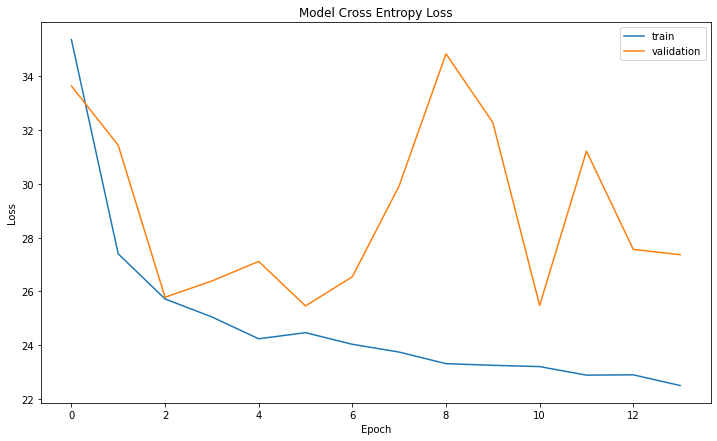

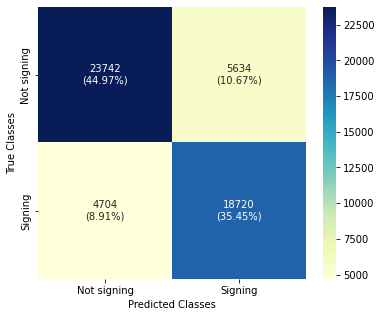

In [12]:
n_a = 16
LSTM_model = deep_bi_lstm_model(Tx, n_x, n_a)
# LSTM_model = base_model(Tx, n_x, n_a)

LSTM_model.compile(optimizer=Adam(learning_rate=0.003), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=0, mode='min', restore_best_weights=True)
LSTM_history = LSTM_model.fit(X_train, list(y_train), epochs=50, batch_size=64, verbose=0, 
                              validation_data=(X_test,list(y_test)), callbacks=[early_stopping])

# single evaluation
single_acc(LSTM_history)
multi_evaluation(X_test_1, X_test_2, test_df_1, test_df_2)
plot(LSTM_history)
plot_confusion_matrix(X_test, test_df)

### Build the attention-based model

Epoch 1/50
105/105 [==============================] - 272s 720ms/step - loss: 33.3107 - dense_1094_loss: 0.5723 - dense_1097_loss: 0.5692 - dense_1100_loss: 0.5666 - dense_1103_loss: 0.5585 - dense_1106_loss: 0.5512 - dense_1109_loss: 0.5566 - dense_1112_loss: 0.5572 - dense_1115_loss: 0.5520 - dense_1118_loss: 0.5481 - dense_1121_loss: 0.5466 - dense_1124_loss: 0.5473 - dense_1127_loss: 0.5441 - dense_1130_loss: 0.5459 - dense_1133_loss: 0.5463 - dense_1136_loss: 0.5529 - dense_1139_loss: 0.5485 - dense_1142_loss: 0.5449 - dense_1145_loss: 0.5452 - dense_1148_loss: 0.5442 - dense_1151_loss: 0.5446 - dense_1154_loss: 0.5455 - dense_1157_loss: 0.5485 - dense_1160_loss: 0.5462 - dense_1163_loss: 0.5429 - dense_1166_loss: 0.5414 - dense_1169_loss: 0.5559 - dense_1172_loss: 0.5512 - dense_1175_loss: 0.5470 - dense_1178_loss: 0.5430 - dense_1181_loss: 0.5429 - dense_1184_loss: 0.5487 - dense_1187_loss: 0.5448 - dense_1190_loss: 0.5494 - dense_1193_loss: 0.5490 - dense_1196_loss: 0.5485 - de

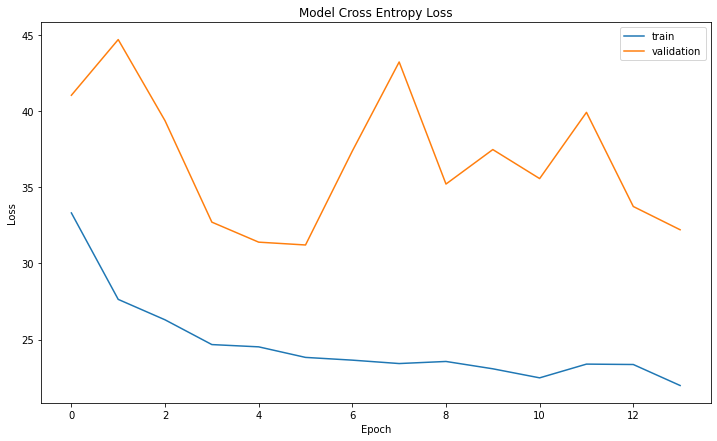

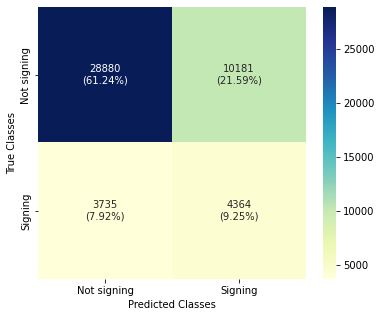

In [22]:
n_a = 32
n_s = 16
m = X_train.shape[0]
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))

m_val = X_test.shape[0]
s0_val = np.zeros((m_val, n_s))
c0_val = np.zeros((m_val, n_s))

LSTM_model = attention_model(Tx, n_a, n_s, n_x)
LSTM_model.compile(optimizer=Adam(learning_rate=0.003), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=0, mode='min', restore_best_weights=True)
LSTM_history = LSTM_model.fit([X_train, s0, c0], list(y_train), epochs=50, batch_size=64, 
                              validation_data=([X_test, s0_val, c0_val],list(y_test)), callbacks=[early_stopping])

# multi evaluation
m_test = X_test_1.shape[0]
s0_test = np.zeros((m_test, n_s))
c0_test = np.zeros((m_test, n_s))

single_acc(LSTM_history)
multi_evaluation([X_test_1, s0_test, c0_test], [X_test_2, s0_test, c0_test], test_df_1, test_df_2)
plot(LSTM_history)
plot_confusion_matrix([X_test, s0_val, c0_val], test_df)